# Changes:
1. Removed images with ambigous mask or too few salt pix
2. Over sample low IOU images.

## Install required packages if running on google colab

In [1]:
try:
    import torch
except:
    !pip install torch torchvision
    !pip install imageio
    !pip install Augmentor
    !git clone https://github.com/allen-q/salt_oil.git
    !git clone https://github.com/allen-q/salt_net.git

In [2]:
cd salt_oil/

[WinError 2] The system cannot find the file specified: 'salt_oil/'
C:\work\code\repos\salt_oil


## Import required libs

In [3]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle
from salt_func_lib import *
from torchvision import transforms, utils
from skimage import io, transform
import datetime as dt
import sys
from optparse import OptionParser
import torch.backends.cudnn as cudnn
from torch import optim
from torch.optim import lr_scheduler
import copy
from io import BytesIO
import Augmentor
import random
import PIL
% matplotlib inline
% load_ext autoreload
% autoreload 2

## Load Unet Modules

In [4]:
from pytorch_unet.eval import eval_net
from pytorch_unet.unet import UNet
from pytorch_unet.unet.unet_parts import *
from pytorch_unet.utils import get_ids, split_ids, split_train_val, get_imgs_and_masks, batch

In [5]:
## Setup data type based on whether GPU is enabled

In [6]:
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!
else:    
    dtype = torch.FloatTensor

In [7]:
print(f'Data Type set to: {dtype}')

Data Type set to: <class 'torch.FloatTensor'>


## Create Global Variables

In [8]:
def init_global_variables():
    """initialize global variables such as db connection, logger etc."""
    global log
    log = get_logger('SaltNet')

In [9]:
init_global_variables()

In [10]:
class SaltDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, np_img, np_mask, df_depth, mean_img, out_size=101, out_ch=1, transform=None):
        """
        Args:
            data_dir (string): Path to the image files.
            train (bool): Load train or test data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.np_img = np_img
        self.np_mask = np_mask.clip(0,1)
        self.df_depth = df_depth
        self.mean_img = mean_img
        self.out_size = out_size
        self.out_ch = out_ch
        self.transform = transform

    def __len__(self):
        return len(self.np_img)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()
            
        X_orig = self.np_img[idx]
        #X = X_orig - self.mean_img

        if self.np_mask is None:
            y = np.zeros((101,101,1))
        else:
            y = self.np_mask[idx]

        if self.transform:
            img_in = PIL.Image.fromarray(np.c_[np.tile(X_orig, 2), y*255])
            #img_in = PIL.Image.fromarray(np.tile(y, 3)*255)
            transformed = np.array(self.transform(img_in))
            X = np.clip(transformed[:,:,0:1]/255, 0., 1.) - self.mean_img
            y = np.clip(transformed[:,:,2:3]/255, 0., 1.)
        else:
            X = np.clip(X_orig/255, 0., 1.) - self.mean_img

        #print(X.dtype)
        
        X = np.moveaxis(X, -1,0)

        pad_size = self.out_size - X.shape[2]
        pad_first = pad_size//2
        pad_last = pad_size - pad_first
        X = np.pad(X, [(0, 0),(pad_first, pad_last), (pad_first, pad_last)], mode='reflect')
        #print(X.dtype)

        #from boxx import g
        #g()

        d = self.df_depth.iloc[idx,0]
        #id = self.df_depth.index[idx]
        #from boxx import g
        #g()
        X = torch.from_numpy(X).float().type(dtype)
        X = X.repeat(self.out_ch,1,1)
        y = transform.resize(y, (101, 101), mode='constant', preserve_range=True)
        y = torch.from_numpy(y).float().squeeze().type(dtype)

        return (X,y,d,idx)

In [321]:
class Pipeline_Salt(Augmentor.Pipeline):
    def __init__(self, source_directory=None, output_directory="output", min_mask_ratio=0., save_format=None):
        super(Pipeline_Salt, self).__init__(source_directory, output_directory, save_format)
        self.min_mask_ratio = min_mask_ratio

    def torch_transform(self):
        """
        Returns the pipeline as a function that can be used with torchvision.

        .. code-block:: python

            >>> import Augmentor
            >>> import torchvision
            >>> p = Augmentor.Pipeline()
            >>> p.rotate(probability=0.7, max_left_rotate=10, max_right_rotate=10)
            >>> p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
            >>> transforms = torchvision.transforms.Compose([
            >>>     p.torch_transform(),
            >>>     torchvision.transforms.ToTensor(),
            >>> ])

        :return: The pipeline as a function.
        """
        def _transform(image):
            for operation in self.operations:
                r = round(random.uniform(0, 1), 1)
                if r <= operation.probability:
                    if not isinstance(image, list):
                        image = [image]
                    if isinstance(operation, Crop):
                        image = _min_mask_crop(image, operation, min_mask_ratio=self.min_mask_ratio)
                    else:
                        image = operation.perform_operation(image)[0]

            return image
        def _min_mask_crop(image, operation, min_mask_ratio=0.):
            '''Crop a image with the mask area not less than min_mask_ratio*original mask area.'''
            img_np = np.array(image[0])
            mask_in = img_np[:,:,2]
            mask_in_pct = (mask_in>0).sum()/mask_in.size
            for i in range(10):    
                img_out = operation.perform_operation(image)[0]
                mask_out = np.array(img_out)[:,:,2]
                mask_out_pct = (mask_out>0).sum()/mask_out.size
                if mask_out_pct >= min_mask_ratio*mask_in_pct:
                    break
            return img_out
            
        return _transform

In [249]:
min_mask_ratio = 0.99

In [254]:
def min_mask_crop(image, operation, min_mask_ratio=0.5):
    img_np = np.array(image[0])
    mask_in = img_np[:,:,2]
    mask_in_pct = (mask_in>0).sum()/mask_in.size
    print(mask_in_pct)
    for i in range(10):    
        print
        img_out = operation.perform_operation(image)[0]
        mask_out = np.array(img_out)[:,:,2]
        mask_out_pct = (mask_out>0).sum()/mask_out.size
        print(mask_out_pct)
        if mask_out_pct >= min_mask_ratio*mask_in_pct:
            break

In [237]:
np.array(image[0]).shape

(101, 101, 3)

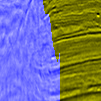

In [221]:
image

In [209]:
isinstance(operation, Crop)

True

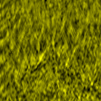

In [79]:
image

In [80]:
img = np.array(image)

In [81]:
img.shape

(101, 101, 3)

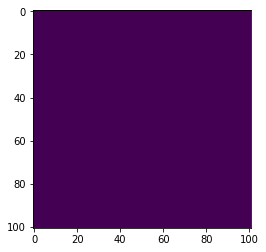

In [82]:
plt.imshow(img[:,:,-1], )

## Prepare Data

### Load train and test data from npy files or from raw images if npy files not exist.

In [27]:
np_train_all, np_train_all_mask, X_test, misc_data = load_all_data()

Try loading data from npy and pickle files...
Data loaded.


### Remove black images

In [28]:
#black_img_ids = (np_train_all.max((1,2,3))==0)

#np_train_all = np_train_all[~black_img_ids]
#np_train_all_mask = np_train_all_mask[~black_img_ids]

In [29]:
np_train_all.shape

(4000, 101, 101, 1)

### Remove images with all black masks

In [30]:
#black_mask_ids = (np_train_all_mask.max((1,2,3))==0)
#np_train_all = np_train_all[~black_mask_ids]
#np_train_all_mask = np_train_all_mask[~black_mask_ids]

### Train Val data split

In [31]:
#np_train_all = np.clip(np_train_all/255, 0, 1)
#X_test = np.clip(X_test/255, 0, 1)

In [32]:
X_train_ids, X_val_ids = (
    train_test_split(np.arange(len(np_train_all)), 
                     test_size=0.20, 
                     random_state=42)
)

In [33]:
with open('./data/df_train_img_iou.pickle', 'rb') as f:
    df_train_img_iou = pickle.load(f)

In [34]:
df_train_img_iou.type.value_counts()

EASY    3584
HARD     416
Name: type, dtype: int64

In [35]:
train_hard_img_id= (
    [misc_data['np_train_all_ids'].index(e) for e in df_train_img_iou.loc[df_train_img_iou.type=='HARD'].id]
)

In [36]:
df_train_img_iou.shape

(4000, 4)

In [37]:
X_train_ids = np.setdiff1d(X_train_ids, train_hard_img_id)

In [38]:
X_train_ids.shape

(2865,)

In [39]:
X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]
depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
#X_train_mean_img = X_train.mean(0).astype(np.float32)
#X_train_mean_img = X_train.mean((0,1,2)).astype(np.float32)
X_train_mean_img = np.clip(np_train_all/255, 0, 1).mean((0,1,2)).astype(np.float32)

all_data = {
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val,
    'X_test': X_test,
    'X_train_mean_img': X_train_mean_img
}

In [18]:
'''hard_img_ids = [ e.split('\\')[-1].split('.')[0].split('_')+['HARD'] for e in glob.glob(f'./data/train_img_pred_hard/*.png')]
df_hard_img_ids = pd.DataFrame(hard_img_ids, columns=['iou', 'id', 'depth', 'type'])
easy_img_ids = [ e.split('\\')[-1].split('.')[0].split('_')+['EASY'] for e in glob.glob(f'./data/train_img_pred_easy/*.png')]
df_easy_img_ids = pd.DataFrame(easy_img_ids, columns=['iou', 'id', 'depth', 'type'])
df_train_img_iou = pd.concat([df_easy_img_ids, df_hard_img_ids])
with open('./data/df_train_img_iou.pickle', 'wb') as f:
    pickle.dump(df_train_img_iou, f)'''

In [25]:
X_train_mean_img

array([0.47194558], dtype=float32)

In [26]:
X_train.shape

(2865, 101, 101, 1)

In [27]:
y_train.shape

(2865, 101, 101, 1)

In [29]:
depth_train.shape

(2865, 1)

In [34]:
df_train_img_iou.head()

,iou,id,depth,type
0,0,003c477d7c,673,EASY
1,0,053a6f6704,559,EASY
2,0,0d3b5ec2a8,516,EASY
3,0,0e63d9a8b4,515,EASY
4,0,0f7aa746d6,314,EASY


In [35]:
df_train_img_iou.shape

(3200, 4)

In [ ]:
depth_train['iou'] = df_train_img_iou.set_index('id').iou

In [ ]:
depth_train['weight'] = (100/(depth_train.iou.astype(int).add(20))).round()

In [191]:
from Augmentor.Operations import *

In [302]:
p = Pipeline_Salt(min_mask_ratio=0.9)

p.crop_by_size(probability=1, width=50, height=50, centre=False)

img = np.c_[np.tile(X_train[0], 2), y_train[0]]

img_in = PIL.Image.fromarray(img)

tsfm = p.torch_transform()

img_out = tsfm(img_in)

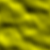

In [320]:
img_out

In [206]:
mask_in = img[:,:,2]

mask_in_pct = (mask>0).sum()/mask_in.size

mask_out = np.array(img_out)[:,:,2]

mask_out_pct = (mask_out>0).sum()/mask_out.size

mask_out_pct

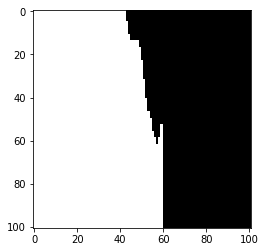

In [133]:
plt.imshow(img[:,:,2].squeeze(), cmap='gray')

In [ ]:
p = Pipeline_Salt()

In [ ]:

#p.skew(probability=1, magnitude=0.5)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=5)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.0, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_by_size(probability=0.5, width=101, height=101, centre=False)


### Create a Train Dataloader

In [272]:
#weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(depth_train['weight'].values, depth_train.shape[0])

train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                    'drop_last': True}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

In [273]:
train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           X_train_mean_img, out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           X_train_mean_img, out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

sample = iter(dataloaders['train']).__next__()

assert sample[0].shape == torch.Size([train_data_params['batch_size'], 1, 128, 128])
assert sample[1].shape == torch.Size([train_data_params['batch_size'], 101, 101])
assert sample[2].shape == torch.Size([train_data_params['batch_size']])
assert sample[3].shape == torch.Size([train_data_params['batch_size']])

0.0
0.0
0.03293794726007254
0.0764
0.0
0.0
0.0
0.0
0.0
0.0
0.5398490344083914
0.0744
0.0
0.0
0.6314086854229978
1.0
0.0
0.0
0.16714047642388002
0.0016
0.21017547299284384
0.1516
0.8822664444662288
1.0
0.0
0.0
0.0
0.0
0.46005293598666797
0.4236
0.237819821586119
0.1904
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5148514851485149
0.58
0.6406234682874228
0.8956
0.0
0.0
0.6082736986569944
0.876
0.0
0.0
0.13792765415155378
0.0
0.18870698951083228
0.0
0.0
0.0
0.15027938437408098
0.0276
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.03293794726007254
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5398490344083914
0.9996
0.0
0.0
0.6314086854229978
0.6212
0.0
0.0
0.16714047642388002
0.0988
0.21017547299284384
0.192
0.8822664444662288
1.0
0.0
0.0
0.0
0.0
0.46005293598666797
0.9096
0.237819821586119
0.2528
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5148514851485149
0.72
0.6406234682874228
0.9568
0.0
0.0
0.6082736986569944
0.3656
0.0
0.0
0.13792765415155378
0.1528
0.18870698951083228
0.0932
0.0
0.0
0.15027938437408098
0.0096
0.0
0.0
0.0
0.0
0.0
0.0


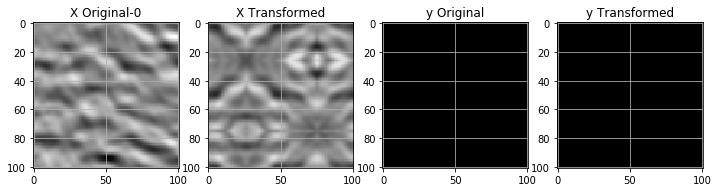

0.5380845015194589
0.6508
0.0
0.0
0.6738555043623174
0.9632
0.317419860797961
0.014
0.0
0.0
0.6357219880403882
0.6804
0.0
0.0
0.0
0.0
0.5660229389275562
0.6492
0.0
0.0
0.9501029310851877
1.0
0.508773649642192
0.2252
0.7026762082148809
0.99
0.0
0.0
0.9504950495049505
0.9104
0.7021860601901775
0.4284
0.0
0.0
0.6471914518184492
1.0
0.0
0.0
0.8636408195274973
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7807077737476718
1.0
0.426624840701892
0.58
0.6382707577688462
0.9772
0.4547593373198706
0.6224
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


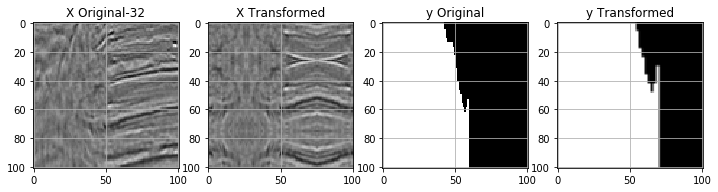

0.1585138711890991
0.0848
0.0
0.0
0.7754141750808744
0.9744
0.8950102931085188
1.0
0.0
0.0
0.4621115576904225
0.392
0.0
0.0
0.5316145475933732
0.7584
0.624938731496912
1.0
0.0
0.0
0.05538672679149103
0.0496
0.0
0.0
0.0
0.0
0.42829134398588375
0.476
0.0
0.0
0.1313596706205274
0.0
0.0
0.0
0.1836094500539163
0.2688
0.0
0.0
0.0
0.0
0.4819135378884423
0.1812
0.24723066366042545
0.2148
0.0
0.0
0.9790216645426919
1.0
0.0
0.0
0.45544554455445546
0.9
0.0
0.0
0.043819233408489366
0.0
0.9973532006666013
1.0
0.006764042740907754
0.0
0.0
0.0
0.7766885599451034
1.0


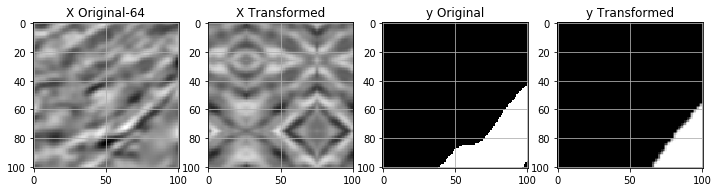

0.0
0.0
0.05009312812469366
0.0048
0.6403293794726007
0.4244
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.05352416429761788
0.0
0.40819527497304187
0.4424
0.0
0.0
0.034310361729242234
0.0064
0.4386824821095971
0.1572
0.0
0.0
0.47907067934516223
0.2564
0.9276541515537693
1.0
0.8516812077247329
0.9872
0.3038917753161455
0.0044
0.2507597294382904
0.0996
0.41839035388687384
0.2468
0.27105185766101364
0.29
0.4808352122340947
0.854
0.6548377610038232
0.9048
0.0
0.0
0.015096559160866581
0.0156
0.0
0.0
0.0
0.0
0.0
0.0
0.027448289383393786
0.0
0.1585138711890991
0.0
0.909910793059504
0.878
0.9870600921478286
1.0
0.013233996666993432
0.0


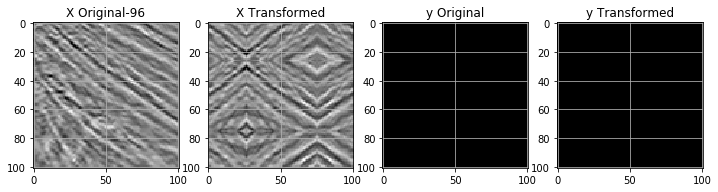

0.0
0.0
0.47867856092539945
0.3472
0.5005391628271738
0.3404
0.13057543378100187
0.2604
0.884129006960102
1.0
0.601411626311146
0.562
0.0
0.0
0.0
0.0
0.0
0.0
0.204391726301343
0.004
0.7283599647093422
0.5016
0.018037447309087344
0.0
0.0
0.0
0.058327614939711794
0.0
0.9246152338006078
1.0
0.37221840995980787
0.2752
0.8656994412312519
0.9596
0.0
0.0
0.3593765317125772
0.5192
0.0
0.0
0.947456131751789
1.0
0.0
0.0
0.5114204489755906
0.624
0.13900597980590138
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.7977649250073522
0.812
0.0
0.0
0.25379864719145184
0.48
0.9393196745417116
1.0
0.15165179884325067
0.0


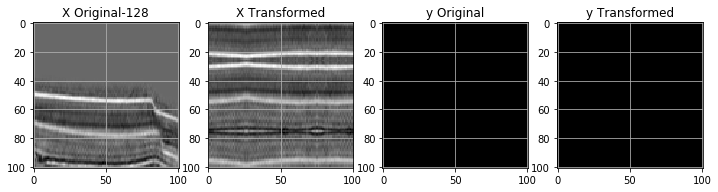

0.0
0.0
0.0
0.0
0.0
0.0
0.8737378688363886
0.9568
0.0
0.0
0.0
0.0
0.7154200568571709
0.9824
0.5690618566807176
0.5132
0.34918145279874524
0.2528
0.0
0.0
0.6752279188314871
0.6232
0.0
0.0
0.316145475933732
0.0096
0.9760807763944711
1.0
0.5721988040388197
0.344
0.39603960396039606
0.58
0.010195078913831977
0.0
0.0
0.0
0.6812077247328693
0.7504
0.0
0.0
0.6458190373492795
1.0
0.8504068228605038
0.9712
0.06616998333496717
0.0
0.0
0.0
0.006371924321144986
0.0
0.9861778257033624
1.0
0.7473777080678364
0.9804
0.0
0.0
0.0
0.0
0.0
0.0
0.659347122831095
0.6344
0.19370649936280757
0.2204


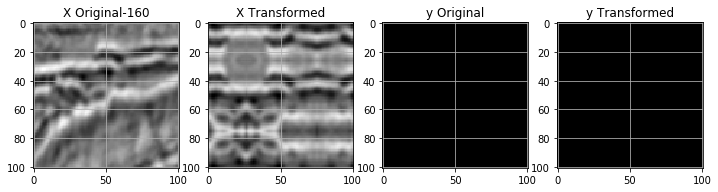

0.0
0.0
0.7728654053524164
1.0
0.0
0.0
0.5576904225075973
0.992
0.0
0.0
0.45397510048034506
0.0684
0.007058131555729831
0.0
0.5562199784334869
0.3996
0.9600039211841976
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.8507989412802667
0.972
0.5647485540633271
0.566
0.9993137927654152
1.0
0.38427605136751297
0.0208
0.36241544946573867
0.4436
0.0
0.0
0.0
0.0
0.9481423389863739
1.0
0.0
0.0
0.5779825507303206
0.1516
0.0
0.0
0.5599451034212332
0.8396
0.0
0.0
0.8334477012057642
1.0
0.0
0.0
0.13537888442309579
0.0
0.20801882168414862
0.3244
0.0
0.0
0.14047642388001177
0.0
0.09871581217527693
0.0008


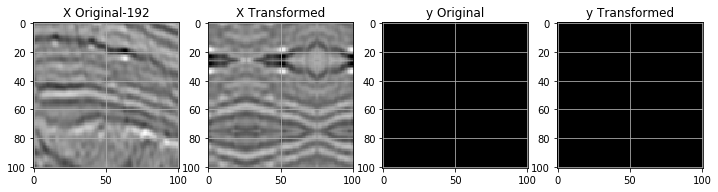

0.0
0.0
0.8590334280952848
0.9992
0.8937359082442897
1.0
0.0
0.0
0.4134888736398392
0.0
0.2305656308205078
0.05
0.0
0.0
0.0
0.0
0.9997059111851779
1.0
0.9309871581217528
0.9304
0.09106950298990295
0.0
0.0
0.0
0.0
0.0
0.22105675914126066
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.1499852955592589
0.0
0.0
0.0
0.0
0.0
0.14655425938633468
0.0
0.016763062444858347
0.0
0.0
0.0
0.0
0.0
0.42319380452896777
0.656
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.26203313400646994
0.2112
0.20625428879521615
0.1272


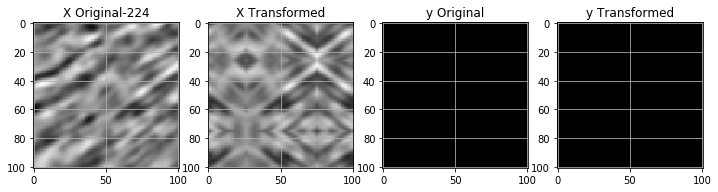

0.0
0.0
0.0
0.0
0.20350945985687677
0.0
0.0
0.0
0.9850995000490148
1.0
0.17664934810312716
0.0
0.0
0.0
0.012743848642289972
0.044
0.35104401529261836
0.0
0.3607489461817469
0.3252
0.9638270757768846
0.976
0.0
0.0
0.6954220174492697
0.8976
0.0
0.0
0.0
0.0
0.5588667777668856
0.4948
0.5686697382609548
0.8384
0.9862758553083031
1.0
0.0
0.0
0.0
0.0
0.10851877266934615
0.2436
0.3054602489951965
0.0
0.5105381825311244
0.1212
0.22389961768454072
0.0964
0.5451426330751887
0.8048
0.9068718753063425
0.7176
0.0
0.0
0.0
0.0
0.0
0.0
0.14557396333692776
0.3464
0.023625134790706794
0.0
0.23732967356141554
0.0


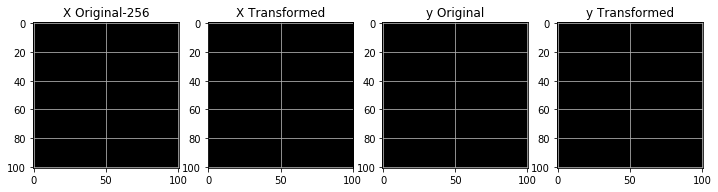

0.0
0.0
0.8281541025389668
0.938
0.0
0.0
0.44456425840603864
0.5656
0.0
0.0
0.0
0.0
0.452406626801294
0.2968
0.48112930104891677
0.9392
0.0
0.0
0.0
0.0
0.9956866973826095
1.0
0.0
0.0
0.7194392706597392
0.9284
0.6438584452504656
0.962
0.0
0.0
0.0
0.0
0.7623762376237624
0.6
0.36408195274973043
0.3996
0.6671894912263504
0.7976
0.26203313400646994
0.3548
0.0
0.0
0.0
0.0
0.611606705224978
0.0004
0.04979903930987158
0.0372
0.28977551220468584
0.0
0.875502401725321
1.0
0.0
0.0
0.0
0.0
0.15165179884325067
0.2128
0.32290951867463974
0.5432
0.2627193412410548
0.434
0.0
0.0


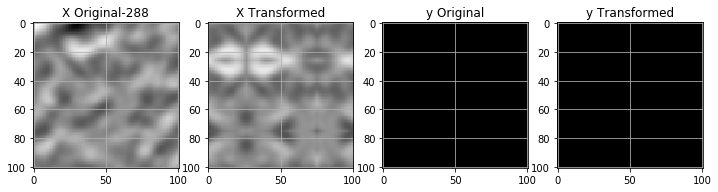

0.0
0.0
0.0
0.0
0.0
0.0
0.4509361827271836
0.4408
0.0
0.0
0.0
0.0
0.0
0.0
0.7201254778943241
0.6944
0.44877953141848836
0.82
0.0
0.0
0.4421135182825213
0.8244
0.41593961376335653
0.6996
0.6251347907067935
0.5644
0.2304676012155671
0.0
0.5545534751494952
0.9968
0.0
0.0
0.06754239780413684
0.0
0.0
0.0
0.9860797960984217
1.0
0.33143809430447996
0.0
0.0
0.0
0.9996078815802373
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.04656406234682874
0.0
0.2797764925007352
0.3784
0.0
0.0
0.0
0.0
0.0
0.0
0.20223507499264778
0.0


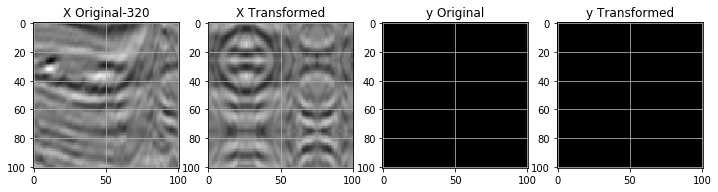

0.9789236349377513
1.0
0.28418782472306636
0.0912
0.0
0.0
0.0
0.0
0.66571904715224
0.634
0.0
0.0
0.5391628271738065
0.4368
0.4037839427507107
0.0624
0.017057151259680423
0.0
0.9890206842466425
1.0
0.2613469267718851
0.1356
0.5841584158415841
0.3128
0.9194196647387511
0.9708
0.9879423585922948
1.0
0.0
0.0
0.9995098519752965
1.0
0.0
0.0
0.08861876286638565
0.0984
0.22007646309185375
0.0
0.0
0.0
0.03930987158121753
0.0
0.3068326634643662
0.0
0.8459954906381727
1.0
0.0
0.0
0.3596706205273993
0.038
0.0
0.0
0.8528575629840212
1.0
0.0
0.0
0.0
0.0
0.1312616410155867
0.0
0.009704930889128516
0.0
0.029800999901970396
0.0


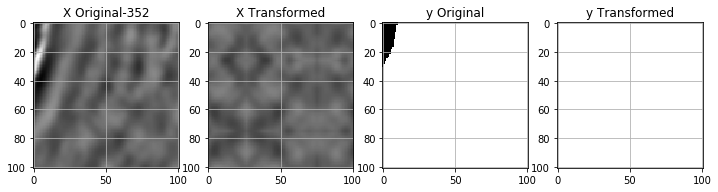

0.0
0.0
0.0
0.0
0.028232526222919323
0.0
0.7261052837957063
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.38378590334280954
0.72
0.03568277619841192
0.0
0.5680815606313107
0.3316
0.32006666013135965
0.2896
0.8339378492304677
1.0
0.0
0.0
0.0
0.0
0.0595039701990001
0.1312
0.6376825801392021
0.738
0.44319184393686895
0.2984
0.15331830212724243
0.0
0.10400941084207431
0.0
0.0
0.0
0.0
0.0
0.6896382707577688
0.9284
0.0
0.0
0.7139496127830605
1.0
0.0
0.0
0.49044211351828254
0.4416
0.6972845799431429
0.9216
0.0
0.0
0.0
0.0
0.0
0.0
0.556514067248309
1.0


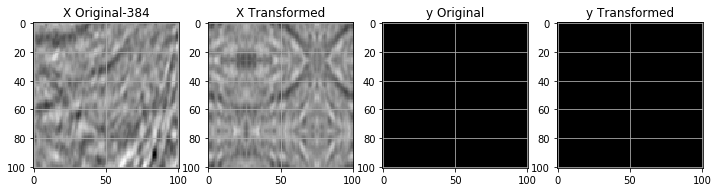

0.0
0.0
0.039603960396039604
0.0948
0.0
0.0
0.0
0.0
0.0
0.0
0.4709342221350848
0.1472
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.08459954906381727
0.0128
0.14194686795412215
0.0
0.09489265758258994
0.0
0.8558964807371826
1.0
0.0
0.0
0.6705224977943339
0.4756
0.0
0.0
0.7438486422899716
1.0
0.9823546711106754
1.0
0.009999019703950594
0.0
0.26487599254975003
0.0
0.2586020978335457
0.3292
0.9126556219978433
1.0
0.0
0.0
0.6598372708557985
0.7416
0.9032447799235369
0.8712
0.0
0.0
0.0
0.0
0.0
0.0
0.1449857857072836
0.0004
0.0
0.0
0.9532398784432898
1.0


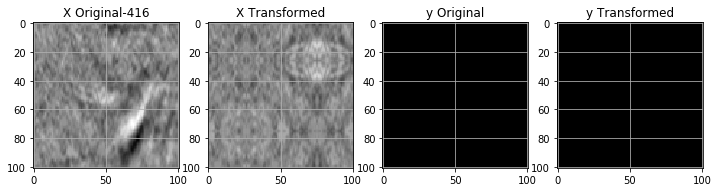

0.4242721301833154
0.5192
0.16282717380648956
0.3568
0.41466522889912755
0.0
0.2293892755612195
0.238
0.25556318008038426
0.0
0.3667287520831291
0.0244
0.4789726497402215
0.7688
0.6003333006567984
0.5
0.7127732575237722
0.646
0.0
0.0
0.2233114400548966
0.0
0.07950200960690128
0.0
0.372806587589452
0.3064
0.0
0.0
0.0
0.0
0.018625624938731496
0.048
0.0
0.0
0.0272522301735124
0.0532
0.0
0.0
0.0
0.0
0.8801097931575336
0.9636
0.0
0.0
0.10361729242231153
0.054
0.16763062444858348
0.0164
0.16968924615233802
0.2496
0.5309283403587883
0.81
0.030585236741495932
0.0
0.2217429663758455
0.0
0.09812763454563278
0.0
0.0
0.0
0.0
0.0
0.9338300166650328
1.0


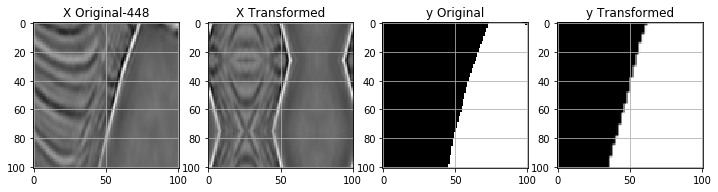

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.48112930104891677
0.7256
0.4583864327026762
0.0512
0.0
0.0
0.43476129791196944
0.8484
0.22203705519066758
0.0
0.09244191745907264
0.0
0.014704440741103813
0.0
0.5677874718164886
0.8524
0.0
0.0
0.008528575629840211
0.0
0.0
0.0
0.015684736790510734
0.0
0.0
0.0
0.44926967944319185
0.2224
0.40094108420743063
0.6
0.5683756494461327
0.616
0.0
0.0
0.0
0.0
0.010881286148416823
0.0
0.0
0.0
0.0
0.0
0.331732183119302
0.1356
0.0
0.0
0.0
0.0
0.0
0.0
0.16272914420154888
0.1676
0.0
0.0
0.5882756592490932
0.3468


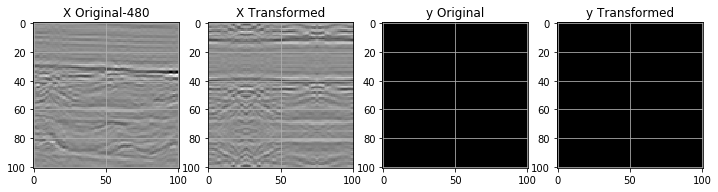

0.40084305460249
0.0
0.0
0.0
0.0
0.0
0.6778747181648858
0.4288
0.054700519556906184
0.0028
0.18909910793059503
0.0028
0.40760709734339773
0.562
0.9799039309871581
1.0
0.0
0.0
0.0
0.0
0.2973237917851191
0.1072
0.0
0.0
0.9075580825409274
0.9184
0.0
0.0
0.30555827860013723
0.372
0.0
0.0
0.07293402607587492
0.0
0.0
0.0
0.5506322909518675
0.2084
0.0
0.0
0.11861582197823743
0.1408
0.09802960494069209
0.0
0.7190471522399765
0.9524
0.06381727281639055
0.0
0.9742182139005979
1.0
0.811194980884227
1.0
0.9225566120968532
1.0
0.0
0.0
0.03274188805019116
0.0
0.6000392118419763
0.932
0.8450151945887658
0.8624
0.0
0.0


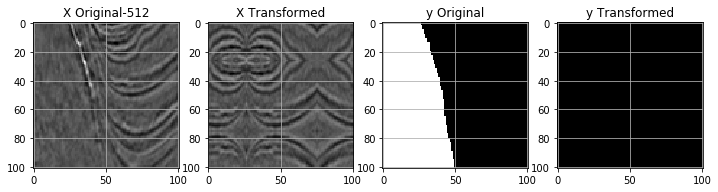

0.35153416331732185
0.4208
0.0
0.0
0.3456523870208803
0.8996
0.0
0.0
0.5331830212724242
0.8788
0.43936868934418194
0.64
0.0
0.0
0.003921184197627684
0.0
0.0
0.0
0.0
0.0
0.5148514851485149
0.08
0.0
0.0
0.0
0.0
0.5223017351240075
0.0004
0.0
0.0
0.0
0.0
0.8156063131065582
0.9564
0.11567493383001666
0.0
0.47024801490049994
0.8596
0.0
0.0
0.0
0.0
0.0
0.0
0.5091657680619547
0.9832
0.0
0.0
0.14920105871973335
0.3712
0.0
0.0
0.0
0.0
0.0
0.0
0.13194784825017156
0.0284
0.1895892559552985
0.0
0.0
0.0
0.0
0.0


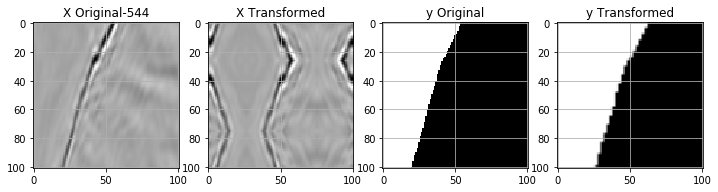

0.0
0.0
0.4154494657386531
0.14
0.9996078815802373
1.0
0.005881776296441525
0.0
0.2367414959317714
0.4112
0.0
0.0
0.7592392902656603
0.9972
0.5974904421135183
1.0
0.0
0.0
0.7965885697480639
0.6144
0.0
0.0
0.15949416723850604
0.0
0.7891383197725713
0.9456
0.562885991569454
0.6
0.0
0.0
0.09891187138515832
0.2904
0.6118027644348594
0.6724
0.0
0.0
0.0
0.0
0.16772865405352416
0.0
0.9761788059994119
1.0
0.0
0.0
0.7995294578962847
0.964
0.0
0.0
0.06793451622389962
0.0
0.9931379276541515
1.0
0.01686109204979904
0.0056
0.0
0.0
0.5214194686795413
0.244
0.2550730320556808
0.5
0.5958239388295266
1.0
0.5032839917655132
0.3188


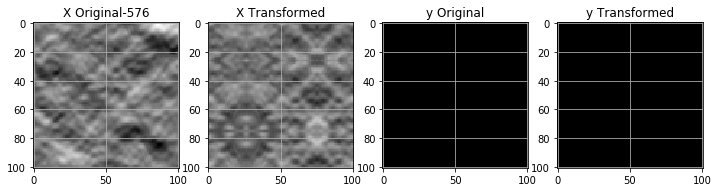

0.45152436035682775
0.5192
0.2081168512890893
0.2892
0.08861876286638565
0.0
0.0
0.0
0.16929712773257524
0.1476
0.2512498774629938
0.0
0.0
0.0
0.006469953926085678
0.0
0.0
0.0
0.10361729242231153
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9919615723948633
1.0
0.0
0.0
0.013528085481815508
0.0
0.0
0.0
0.0
0.0
0.30036270953828054
0.0
0.9208901088128615
0.984
0.3054602489951965
0.1168
0.16400352906577786
0.0
0.3708459954906382
0.4652
0.003234976963042839
0.0
0.04479952945789629
0.0
0.0
0.0
0.0
0.0
0.034310361729242234
0.0
0.003921184197627684
0.0
0.0
0.0
0.0
0.0


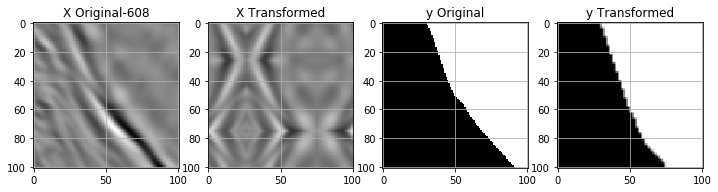

0.0
0.0
0.651700813645721
0.6544
0.01637094402509558
0.0
0.26595431820409765
0.6444
0.0
0.0
0.0
0.0
0.0
0.0
0.9797078717772767
1.0
0.28075678855014213
0.2684
0.20909714733849621
0.0
0.013233996666993432
0.0
0.0
0.0
0.0780315655327909
0.0024
0.9850014704440742
1.0
0.08381531222429174
0.0
0.26585628859915694
0.1712
0.019801980198019802
0.0
0.5602391922360553
0.7204
0.2786981668463876
0.1948
0.0
0.0
0.9950004901480247
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3782962454661308
0.7664
0.7232624252524262
0.6388
0.9828448191353789
1.0
0.12616410155867072
0.0
0.09881384178021763
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [274]:
i = 0
for X_batch, y_batch, d_batch, X_id in dataloaders['train']:
    i+=1
    if i>20:
        break
    X_orig = X_train[X_id[0]].squeeze()/255
    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()[13:114,13:114] + X_train_mean_img.squeeze()
    y_orig = y_train[X_id[0]].squeeze()
    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm],
                       [f'X Original-{X_id[0]}', 'X Transformed', 'y Original', 'y Transformed'])

In [44]:
X_train.shape

(2865, 101, 101, 1)

### Create a Train Dataloader for sanity check

In [ ]:
weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(depth_train['weight'][:8], 2)

train_data_params = {'batch_size': 2,
                   'sampler': weighted_sampler}

val_data_params = {'batch_size': 2,
                   'shuffle': True,
                   'drop_last': False}

In [ ]:
train_dataLoader = (
    DataLoader(SaltDataset(X_train[:8], y_train[:8], depth_train[:8],
                           X_train_mean_img, out_size=128, out_ch=1,
                           transform=None), **train_data_params)
                           #transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val[:4], y_val[:4], depth_val[:4], 
                           X_train_mean_img, out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}


In [ ]:
t = iter(train_dataLoader).__next__()

In [ ]:
X_batch, y_batch, d_batch, X_id = t

In [ ]:
def train_model(model, dataloaders, criterion1, criterion2, optimizer, scheduler, model_save_name, other_data={}, 
                num_epochs=25, print_every=2, save_model_every=None, save_log_every=None, log=get_logger('SaltNet'), loss2_weight=0):
    #args = locals()
    #args = {k:v.shape if isinstance(v, (torch.Tensor, np.ndarray)) else v for k,v in args.items()}
    #args = {k:v.shape if isinstance(v, (torch.Tensor, np.ndarray)) else v for k,v in args.items()}
    log.info('Start Training...')
    #log.info('Passed parameters: {}'.format(args))

    start = time.time()

    if torch.cuda.is_available():
        model.cuda()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_model = None
    best_iou = 0.0
    all_losses = []
    iter_count = 0
    X_train = other_data['X_train']
    X_val = other_data['X_val']
    y_train = other_data['y_train']
    y_val = other_data['y_val']
    X_train_mean_img = other_data['X_train_mean_img']
    mask_cutoff = 0.

    for epoch in range(1, num_epochs+1):
        log.info('Epoch {}/{}'.format(epoch, num_epochs))
        log.info('-' * 20)
        if save_log_every is not None:
            if (epoch % save_log_every == 0):
                push_log_to_git()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_loss1 = []
            epoch_loss2 = []
            pred_vs_true_epoch = []

            for X_batch, y_batch, d_batch, X_id in dataloaders[phase]:
                # zero the parameter gradients
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    #y_pred, y_mask_pred = model(X_batch)
                    y_pred = model(X_batch)
                    pred_vs_true_epoch.append([y_pred, y_batch])
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':                        
                        #from boxx import g
                        #g()
                        #y_batch_mask_pix = y_batch.sum((1,2))
                        #sample_weight = torch.where((y_batch_mask_pix<202) | (y_batch_mask_pix>5000), torch.tensor(1.0).type(dtype), (101**2/y_batch_mask_pix))
                        #sample_weight = torch.ones_like(y_batch) * sample_weight.reshape(-1,1,1)
                        
                        loss_1 = criterion1(y_pred, y_batch.float())      
                        #loss_1 = F.binary_cross_entropy_with_logits(y_pred, y_batch.float(), weight=sample_weight)
                        if (epoch % 50 == 0):
                          loss2_weight = loss2_weight + 0.1
                        loss_2 = loss2_weight * criterion2(y_pred, y_batch.float()) 

                        #print(f'loss_pix: {loss_pix}, loss_dice:{loss_dice}')
                        loss = loss_1 + loss_2
                        #loss = loss_pix
                        all_losses.append(loss.item())
                        epoch_loss1.append(loss_1.item())
                        epoch_loss2.append(loss_2.item())
                        
                        loss.backward()
                        optimizer.step()
                        iter_count += 1
                if (phase == 'train') & (iter_count % print_every == 0):
                    iou_batch = calc_mean_iou(y_pred.ge(mask_cutoff), y_batch.float())
                    iou_acc = calc_clf_accuracy(y_pred.ge(mask_cutoff), y_batch.float())

                    log.info('Batch Loss: {:.4f}, Epoch loss_1: {:.4f}, Epoch loss_2: {:.4f}, Batch IOU: {:.4f}, Batch Acc: {:.4f} at iter {}, epoch {}, Time: {}'.format(
                        np.mean(all_losses[-print_every:]), np.mean(epoch_loss1), np.mean(epoch_loss2), iou_batch, iou_acc, iter_count, epoch, timeSince(start))
                    )
                    #print(all_losses)
                    X_orig = X_train[X_id[0]].squeeze()/255
                    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()
                    X_tsfm = transform.resize(X_tsfm, (128, 128), mode='constant', preserve_range=True)
                    X_tsfm = X_tsfm[13:114,13:114] + X_train_mean_img.squeeze()
                    #X_tsfm = X_batch[0][X_batch[0].sum((1,2)).argmax()].squeeze().cpu().detach().numpy()[:101,:101] + X_train_mean_img.squeeze()

                    y_orig = y_train[X_id[0]].squeeze()
                    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
                    y_tsfm_pred =  y_pred[0].squeeze().gt(mask_cutoff)
                    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm, y_tsfm_pred],
                                       ['X Original', 'X Transformed', 'y Original', 'y Transformed', 'y Predicted'])

            y_pred_epoch = torch.cat([e[0] for e in pred_vs_true_epoch])
            y_true_epoch = torch.cat([e[1] for e in pred_vs_true_epoch])
            #from boxx import g
            #g()
            mean_iou_epoch = calc_mean_iou(y_pred_epoch.ge(mask_cutoff), y_true_epoch.float())
            mean_acc_epoch = calc_clf_accuracy(y_pred_epoch.ge(mask_cutoff), y_true_epoch.float())
            log.info('{} Mean IOU: {:.4f}, Mean Acc: {:.4f}, Best Val IOU: {:.4f} at epoch {}'.format(phase, mean_iou_epoch, mean_acc_epoch, best_iou, epoch))
            if phase == 'val' and mean_iou_epoch > best_iou:
                best_iou = mean_iou_epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                stats = {'best_iou': best_iou,
                         'all_losses': all_losses,
                         'iter_count': iter_count}
                log.info(save_model_state_to_chunks(epoch, copy.deepcopy(model.state_dict()),
                                                    copy.deepcopy(optimizer.state_dict()),
                                                    copy.deepcopy(scheduler.state_dict()), stats, model_save_name, '.'))
                best_model = (epoch, copy.deepcopy(model.state_dict()),
                                                    copy.deepcopy(optimizer.state_dict()),
                                                    copy.deepcopy(scheduler.state_dict()), stats, model_save_name, '.')
                log.info('Best Val Mean IOU so far: {}'.format(best_iou))
                # Visualize 1 val sample and predictions
                X_orig = X_val[X_id[0]].squeeze()/255
                y_orig = y_val[X_id[0]].squeeze()
                y_pred2 =  y_pred[0].squeeze().gt(mask_cutoff)
                plot_img_mask_pred([X_orig, y_orig, y_pred2],
                                   ['Val X Original', 'Val y Original', 'Val y Predicted'])
        if save_model_every is not None:
            if (epoch % save_model_every == 0) | (epoch == num_epochs-1):
                if (best_model is not None) and (best_iou>0.80):
                    log.info(save_model_state_to_chunks(*best_model))                
                    push_model_to_git(ckp_name=model_save_name)
                    best_model = None
                else:
                    log.info("Skip pushing model to git as there's no improvement")

    # load best model weights
    model.load_state_dict(best_model_wts)
    log.info('-' * 20)
    time_elapsed = time.time() - start
    log.info('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    log.info('Best val IOU: {:4f}'.format(best_iou))

    return model

## Train the model using a small data set to see if it can overfit

In [ ]:
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)

In [ ]:
#saltnet = resnet34unet(in_ch=3, bilinear=False, pretrained=False)

loss_fn_bce = nn.BCEWithLogitsLoss()
loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()

optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.01)

scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

model_save_name = None

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_focal, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=100, print_every=2, save_model_every=None, save_log_every=None, log=log, loss2_weight=0.005)

## Train the full with full dataset

In [45]:
log.info('removed hard images with ambiguous masks. Over sample images with low IOU.')

09/09/2018 14:16:38 - SaltNet - INFO - removed hard images with ambiguous masks. Over sample images with low IOU.


In [ ]:
model_config = '''
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)
loss_fn_bce = nn.BCEWithLogitsLoss()
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_data_preprocess_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=300, print_every=50, save_model_every=20, save_log_every=2, log=log, loss2_weight=0.1)
'''

In [47]:
log.info(model_config)

09/09/2018 14:16:42 - SaltNet - INFO - 
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)
loss_fn_bce = nn.BCEWithLogitsLoss()
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_data_preprocess_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=300, print_every=50, save_model_every=20, save_log_every=2, log=log, loss2_weight=0.1)



In [ ]:
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)
loss_fn_bce = nn.BCEWithLogitsLoss()
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_data_preprocess_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=300, print_every=50, save_model_every=20, save_log_every=2, log=log, loss2_weight=0.1)

09/09/2018 14:53:50 - SaltNet - INFO - ../salt_net/Unet_bce_loss_lovasz_loss_data_preprocess_2018_09_10_00_17_44.ckp
09/09/2018 14:53:50 - SaltNet - INFO - Start Training...
09/09/2018 14:53:50 - SaltNet - INFO - Epoch 1/300
09/09/2018 14:53:50 - SaltNet - INFO - --------------------


Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
## Fine tune

In [ ]:
p = Pipeline_Salt()
#p.skew(probability=1, magnitude=0.5)
#p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=5)
#p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
#p.zoom(probability=0.5, min_factor=1.0, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
#p.crop_by_size(probability=0.5, width=101, height=101, centre=False)
data_params = {'batch_size': 32,
               'shuffle': True,
               'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           X_train_mean_img, out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           X_train_mean_img, out_size=128, out_ch=1), **data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}


In [ ]:
log.info('Change transfomer to use only shear(-10 to 10) and hflip. Increase loss 2 weight to 0.5. change lr to 0.001')

In [ ]:
#saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)
loss_fn_bce = nn.BCEWithLogitsLoss()
loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

#model_save_name = f'../salt_net/Unet_focal_loss_lovasz_loss_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_focal, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=200, print_every=50, save_model_every=20, save_log_every=2, log=log, loss2_weight=0.5)

## Load Trained Model

In [ ]:
loaded_model = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)

In [ ]:
cd ../salt_net

In [ ]:
model_file_suffix = "Unet_bce_loss_lovasz_loss_2018_09_05_23_54_40.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
loaded_model.load_state_dict(model_state_dict['model'])

### Make Predictions on validation set

### Set model to evaluation mode

In [ ]:
loaded_model.eval()
assert loaded_model.training == False

In [ ]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img, out_size=128), batch_size=16)

In [ ]:
if torch.cuda.is_available():
    loaded_model.cuda()

In [ ]:
y_val_pred = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred.append(loaded_model(X_val_batch))
y_val_pred = torch.cat(y_val_pred)

In [ ]:
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img, out_size=128), batch_size=16)
y_train_pred = []

with torch.no_grad():
    for X_train_batch, y_train_batch, depth_train_batch, X_train_id_batch in train_dataLoader:
        y_train_pred.append(loaded_model(X_train_batch))
y_train_pred = torch.cat(y_train_pred)

In [ ]:
for i in range(10):
    rand_id = np.random.choice(X_val_id_batch)
    print(f'Image ID: {rand_id}')
    val_img = X_val[rand_id]/255
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([val_img, val_mask, val_mask_pred], range(3), img_per_line=3)

In [ ]:
for i in range(10):
    rand_id = np.random.choice(X_train_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_train[rand_id]/255
    mask = y_train[rand_id]
    mask_pred = y_train_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([img, mask, mask_pred], range(3), img_per_line=3)

In [ ]:
ZERO_MASK_CUTOFF = 50
MASK_CUTOFF = 0.

In [ ]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze())

In [ ]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze())

In [ ]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze()), y_val.squeeze()))

In [ ]:
range(0, 300, 10)[np.argmax(results)]

In [ ]:
results

In [ ]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze())

In [ ]:
y_train_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_train, y_train_pred.gt(MASK_CUTOFF), y_train.squeeze())

In [ ]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_train, y_train_pred.gt(MASK_CUTOFF), y_train.squeeze()), y_train.squeeze()))

In [ ]:
range(0, 3000, 10)[np.argmax(results)]

## Make predictions on test set

In [ ]:
#test_dataLoader = DataLoader(SaltDataset(np_test[:10], None, depth_test, X_train_mean_img), batch_size=4)
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128), batch_size=16)

In [ ]:
y_test_pred_raw = []
with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_raw.append(loaded_model(X_test_batch))
y_test_pred = torch.cat(y_test_pred_raw)

### Show segmentation masks for a few images

In [ ]:
for i in range(10):
    rand_id = np.random.choice(X_test_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_test[rand_id]/255
    mask_pred = y_test_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([img, mask_pred], range(2))

### Adjust predictions

In [ ]:
 ZERO_MASK_CUTOFF = 20

In [ ]:
y_test_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_test, y_test_pred.gt(MASK_CUTOFF))

### Encode predictions using RLE(Run Length Encoding) method

In [ ]:
y_test_pred_rle = rle_encoder3d(y_test_pred_adj)

In [ ]:
y_test_pred_adj.shape

In [ ]:
df_test_rle = pd.DataFrame(index=misc_data['np_test_ids'], data=y_test_pred_rle).reset_index()

In [ ]:
df_test_rle.columns = ['id', 'rle_mask']

In [ ]:
df_test_rle[df_test_rle.rle_mask==''].shape

In [ ]:
df_test_rle.shape

In [ ]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)

In [ ]:
ls

In [ ]:
from google.colab import files


In [ ]:
files.download('submission_2018_09_06_11_44_03.csv') 

In [ ]:
import numpy as np